In [11]:
import copy
import gc
import json
import os
from pathlib import Path
import sys
import time
import traceback
from typing import List, Tuple, Dict, Union, Optional
import warnings
import numpy as np
import torch
from anndata import AnnData
import scanpy as sc
import scvi
import numpy as npddddd
import wandb
from scipy.sparse import issparse
import matplotlib.pyplot as plt
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchtext.vocab import Vocab
from torchtext._torchtext import (
    Vocab as VocabPybind,
)

from Sophia import SophiaG 

from scgpt.tokenizer.gene_tokenizer import GeneVocab

sys.path.append("../")
import scgpt as scg
from scgpt.model import TransformerModel, AdversarialDiscriminator
from scgpt.tokenizer import tokenize_and_pad_batch, random_mask_value
from scgpt.loss import (
    masked_mse_loss,
    masked_relative_error,
    criterion_neg_log_bernoulli,
    masked_ce_loss
)
from scgpt.preprocess import Preprocessor
from scgpt import SubsetsBatchSampler
from scgpt.utils import set_seed, category_str2int, eval_scib_metrics

# from functions_group import DistanceLoss

sc.set_figure_params(figsize=(4, 4))
os.environ["KMP_WARNINGS"] = "off"
# os.environ["WANDB_MODE"] = "offline"

# hyperparameter_defaults = dict(
#     seed=42,
#     dataset_name="PBMC_10K",
#     do_train=True,
#     load_model="save/scGPT_bc",
#     mask_ratio=0.1,
#     epochs=10,
#     n_bins=10001,
#     GEPC=True,  # Masked value prediction for cell embedding
#     ecs_thres=0.8,  # Elastic cell similarity objective, 0.0 to 1.0, 0.0 to disable
#     dab_weight=10.0,
#     lr=1e-4,
#     batch_size=64,
#     layer_size=128,
#     nlayers=4,
#     nhead=4,
#     # if load model, batch_size, layer_size, nlayers, nhead will be ignored
#     dropout=0.2,
#     schedule_ratio=0.9,  # ratio of epochs for learning rate schedule
#     save_eval_interval=5,
#     log_interval=10,
#     fast_transformer=True,
#     pre_norm=False,
#     amp=True,  # Automatic Mixed Precision
# )

# modify original param
hyperparameter_defaults = dict(
    seed=42,
    dataset_name="PBMC_10K",
    do_train=True,
    load_model="save/scGPT_bc",
    mask_ratio=0.4,
    epochs=1,
    n_bins=51,
    GEPC=True,  # Masked value prediction for cell embedding
    ecs_thres=0.8,  # Elastic cell similarity objective, 0.0 to 1.0, 0.0 to disable
    dab_weight=1.0,
    lr=1e-4,
    batch_size=32,
    layer_size=128,
    nlayers=4,
    nhead=4,
    # if load model, batch_size, layer_size, nlayers, nhead will be ignored
    dropout=0.2,
    schedule_ratio=0.9,  # ratio of epochs for learning rate schedule
    save_eval_interval=5,
    log_interval=100,
    fast_transformer=True,
    pre_norm=False,
    amp=True,  # Automatic Mixed Precision
)

run = wandb.init(
    config=hyperparameter_defaults,
    project="scGPT",
    reinit=True,
    settings=wandb.Settings(start_method="fork"),
)
config = wandb.config
print(config)

/gpfs/gibbs/project/zhao/tl688/conda_envs/scgpt/lib/python3.8/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)
/gpfs/gibbs/project/zhao/tl688/conda_envs/scgpt/lib/python3.8/site-packages/wandb/sdk/lib/ipython.py:70: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


/gpfs/gibbs/project/zhao/tl688/conda_envs/scgpt/lib/python3.8/site-packages/wandb/sdk/lib/ipython.py:82: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


/gpfs/gibbs/project/zhao/tl688/conda_envs/scgpt/lib/python3.8/site-packages/wandb/sdk/lib/ipython.py:82: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


/gpfs/gibbs/project/zhao/tl688/conda_envs/scgpt/lib/python3.8/site-packages/wandb/sdk/lib/ipython.py:70: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


{'seed': 42, 'dataset_name': 'PBMC_10K', 'do_train': True, 'load_model': 'save/scGPT_bc', 'mask_ratio': 0.4, 'epochs': 1, 'n_bins': 51, 'GEPC': True, 'ecs_thres': 0.8, 'dab_weight': 1.0, 'lr': 0.0001, 'batch_size': 32, 'layer_size': 128, 'nlayers': 4, 'nhead': 4, 'dropout': 0.2, 'schedule_ratio': 0.9, 'save_eval_interval': 5, 'log_interval': 100, 'fast_transformer': True, 'pre_norm': False, 'amp': True}


In [12]:
# adata = sc.read_h5ad("/gpfs/gibbs/pi/zhao/tl688/tangram/ST-LN-compressed.h5ad")
adata = sc.read_h5ad("/gpfs/gibbs/pi/zhao/tl688/scGPT/examples/mouse_spatial.h5ad")
print(adata)

ori_batch_col = "batch"
adata.obs['batch'] = list(adata.obs['in_tissue'])
adata.obs['celltype'] = list(adata.obs['cluster'])
adata.obs["celltype"] = adata.obs["celltype"].astype("category")
adata.var_names = [i.upper() for i in adata.var_names]
data_is_raw = True


# %%
# make the batch category column 
adata.obs["str_batch"] = adata.obs[ori_batch_col].astype(str)
batch_id_labels = adata.obs["str_batch"].astype("category").cat.codes.values
adata.obs["batch_id"] = batch_id_labels

adata.var["gene_name"] = adata.var.index.tolist()

if config.load_model is not None:
    model_dir = Path(config.load_model)
    model_config_file = model_dir / "args.json"
    model_file = model_dir / "best_model.pt"
    vocab_file = model_dir / "vocab.json"

    vocab = GeneVocab.from_file(vocab_file)
    for s in special_tokens:
        if s not in vocab:
            vocab.append_token(s)

    adata.var["id_in_vocab"] = [
        1 if gene in vocab else -1 for gene in adata.var["gene_name"]
    ]
    gene_ids_in_vocab = np.array(adata.var["id_in_vocab"])
    logger.info(
        f"match {np.sum(gene_ids_in_vocab >= 0)}/{len(gene_ids_in_vocab)} genes "
        f"in vocabulary of size {len(vocab)}."
    )
    adata = adata[:, adata.var["id_in_vocab"] >= 0]

    # model
    with open(model_config_file, "r") as f:
        model_configs = json.load(f)
    logger.info(
        f"Resume model from {model_file}, the model args will override the "
        f"config {model_config_file}."
    )
    embsize = model_configs["embsize"]
    nhead = model_configs["nheads"]
    d_hid = model_configs["d_hid"]
    nlayers = model_configs["nlayers"]
    n_layers_cls = model_configs["n_layers_cls"]

AnnData object with n_obs × n_vars = 324 × 16562
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT', 'log1p_total_counts_MT', 'pct_counts_MT', 'n_counts', 'leiden', 'cluster'
    var: 'gene_ids', 'feature_types', 'genome', 'MT', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cluster_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
scGPT - INFO - match 13444/16562 genes in vocabulary of size 36574.
scGPT - INFO - Resume model from save/scGPT_bc/best_model.pt, the model 

In [13]:
adata.obs

,in_tissue,array_row,array_col,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,...,total_counts_MT,log1p_total_counts_MT,pct_counts_MT,n_counts,leiden,cluster,batch,celltype,str_batch,batch_id
AAATGGCATGTCTTGT-1,1,13,69,5191,8.554874,15977.0,9.678968,20.629655,26.757213,34.743694,...,0.0,0.0,0.0,15977.0,0,Cortex_1,1,Cortex_1,1,0
AACAACTGGTAGTTGC-1,1,28,42,5252,8.566555,16649.0,9.720165,20.481711,26.277855,34.092138,...,0.0,0.0,0.0,16649.0,0,Cortex_1,1,Cortex_1,1,0
AACAGGAAATCGAATA-1,1,15,67,6320,8.751633,23375.0,10.059465,17.929412,23.850267,32.077005,...,0.0,0.0,0.0,23375.0,0,Cortex_1,1,Cortex_1,1,0
AACCCAGAGACGGAGA-1,1,15,39,3659,8.205218,9229.0,9.130215,25.939972,31.964460,39.885145,...,0.0,0.0,0.0,9229.0,1,Cortex_2,1,Cortex_2,1,0
AACCGTTGTGTTTGCT-1,1,12,64,4512,8.414717,12679.0,9.447782,21.839262,28.038489,36.209480,...,0.0,0.0,0.0,12679.0,0,Cortex_1,1,Cortex_1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGGATTGGGTACCAC-1,1,17,55,4980,8.513386,15381.0,9.640953,21.038944,27.059359,35.114752,...,0.0,0.0,0.0,15381.0,0,Cortex_1,1,Cortex_1,1,0
TTGGCTCGCATGAGAC-1,1,23,37,4620,8.438366,13193.0,9.487517,20.609414,26.445842,34.063519,...,0.0,0.0,0.0,13193.0,5,Cortex_3,1,Cortex_3,1,0
TTGTATCACACAGAAT-1,1,12,74,6120,8.719481,21951.0,9.996614,18.199626,24.235798,32.440436,...,0.0,0.0,0.0,21951.0,0,Cortex_1,1,Cortex_1,1,0
TTGTGGCCCTGACAGT-1,1,18,60,4971,8.511577,14779.0,9.601030,21.381690,27.924758,36.213546,...,0.0,0.0,0.0,14779.0,0,Cortex_1,1,Cortex_1,1,0


In [14]:
preprocessor = Preprocessor(
    use_key="X",  # the key in adata.layers to use as raw data
    filter_gene_by_counts=3,  # step 1
    filter_cell_by_counts=False,  # step 2
    normalize_total=1e4,  # 3. whether to normalize the raw data and to what sum
    result_normed_key="X_normed",  # the key in adata.layers to store the normalized data
    log1p=data_is_raw,  # 4. whether to log1p the normalized data
    result_log1p_key="X_log1p",
    subset_hvg=False,  # 5. whether to subset the raw data to highly variable genes
    hvg_flavor="seurat_v3" if data_is_raw else "cell_ranger",
    binning=config.n_bins,  # 6. whether to bin the raw data and to what number of bins
    result_binned_key="X_binned",  # the key in adata.layers to store the binned data
)
preprocessor(adata, batch_key="batch" if dataset_name != "heart_cell" else None)

# %%
if per_seq_batch_sample:
    # sort the adata by batch_id in advance
    adata_sorted = adata[adata.obs["batch_id"].argsort()].copy()

# %% [markdown]
# ## Tokenize input

# %%
input_layer_key = "X_binned"
all_counts = (
    adata.layers[input_layer_key].A
    if issparse(adata.layers[input_layer_key])
    else adata.layers[input_layer_key]
)
genes = adata.var["gene_name"].tolist()

celltypes_labels = adata.obs["celltype"].tolist()  # make sure count from 0
num_types = len(set(celltypes_labels))
celltypes_labels = np.array(celltypes_labels)

batch_ids = adata.obs["batch_id"].tolist()
num_batch_types = len(set(batch_ids))
batch_ids = np.array(batch_ids)

scGPT - INFO - Filtering genes by counts ...
scGPT - INFO - Filtering cells by counts ...
scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Log1p transforming ...
scGPT - WARNING - The input data seems to be already log1p transformed. Set `log1p=False` to avoid double log1p transform.
scGPT - INFO - Binning data ...


/gpfs/gibbs/project/zhao/tl688/conda_envs/scgpt/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:249: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_counts'] = number


In [15]:
adata

AnnData object with n_obs × n_vars = 324 × 11968
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT', 'log1p_total_counts_MT', 'pct_counts_MT', 'n_counts', 'leiden', 'cluster', 'batch', 'celltype', 'str_batch', 'batch_id'
    var: 'gene_ids', 'feature_types', 'genome', 'MT', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'gene_name', 'id_in_vocab', 'n_counts'
    uns: 'cluster_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'spatial', 'umap', 'log1p'
    obsm: 'X_pca', 'X_umap', 'spatial', 'bin_edges'
    varm: 'PCs'
    layers: 'X_normed', 'X_log1p', 'X_binned'
    obsp: 'connectivities'

In [16]:
# %%
# settings for input and preprocessing
pad_token = "<pad>"
special_tokens = [pad_token, "<cls>", "<eoc>"]
mask_ratio = config.mask_ratio
mask_value = -1
pad_value = -2
n_input_bins = config.n_bins

n_hvg = len(adata.var_names)  # number of highly variable genes
max_seq_len = n_hvg + 1
per_seq_batch_sample = False
DSBN = True  # Domain-spec batchnorm
explicit_zero_prob = True  # whether explicit bernoulli for zeros

# %%
dataset_name = config.dataset_name
save_dir = Path(f"./save/dev_{dataset_name}-{time.strftime('%b%d-%H-%M')}/")
save_dir.mkdir(parents=True, exist_ok=True)
print(f"save to {save_dir}")
# save the whole script to the dir
# os.system(f"cp {__file__} {save_dir}")

logger = scg.logger
scg.utils.add_file_handler(logger, save_dir / "run.log")

save to save/dev_PBMC_10K-Jul26-22-27


In [17]:
# %%
input_layer_key = "X_binned"
all_counts = (
    adata.layers[input_layer_key].A
    if issparse(adata.layers[input_layer_key])
    else adata.layers[input_layer_key]
)
genes = adata.var["gene_name"].tolist()

celltypes_labels = adata.obs["celltype"].tolist()  # make sure count from 0
num_types = len(set(celltypes_labels))
celltypes_labels = np.array(celltypes_labels)

batch_ids = adata.obs["batch_id"].tolist()
num_batch_types = len(set(batch_ids))
batch_ids = np.array(batch_ids)

(
    train_data,
    valid_data,
    train_celltype_labels,
    valid_celltype_labels,
    train_batch_labels,
    valid_batch_labels,
) = train_test_split(
    all_counts, celltypes_labels, batch_ids, test_size=0.001, shuffle=True
)

# %%
if config.load_model is None:
    vocab = Vocab(
        VocabPybind(genes + special_tokens, None)
    )  # bidirectional lookup [gene <-> int]
vocab.set_default_index(vocab["<pad>"])
gene_ids = np.array(vocab(genes), dtype=int)

In [18]:
# %%
if config.load_model is None:
    vocab = Vocab(
        VocabPybind(genes + special_tokens, None)
    )  # bidirectional lookup [gene <-> int]
vocab.set_default_index(vocab["<pad>"])
gene_ids = np.array(vocab(genes), dtype=int)

# %%
tokenized_train = tokenize_and_pad_batch(
    train_data,
    gene_ids,
    max_len=max_seq_len,
    vocab=vocab,
    pad_token=pad_token,
    pad_value=pad_value,
    append_cls=True,  # append <cls> token at the beginning
    include_zero_gene=True,
)
tokenized_valid = tokenize_and_pad_batch(
    valid_data,
    gene_ids,
    max_len=max_seq_len,
    vocab=vocab,
    pad_token=pad_token,
    pad_value=pad_value,
    append_cls=True,
    include_zero_gene=True,
)
logger.info(
    f"train set number of samples: {tokenized_train['genes'].shape[0]}, "
    f"\n\t feature length: {tokenized_train['genes'].shape[1]}"
)
logger.info(
    f"valid set number of samples: {tokenized_valid['genes'].shape[0]}, "
    f"\n\t feature length: {tokenized_valid['genes'].shape[1]}"
)


# %%
def prepare_data(sort_seq_batch=False) -> Tuple[Dict[str, torch.Tensor]]:
    masked_values_train = random_mask_value(
        tokenized_train["values"],
        mask_ratio=mask_ratio,
        mask_value=mask_value,
        pad_value=pad_value,
    )
    masked_values_valid = random_mask_value(
        tokenized_valid["values"],
        mask_ratio=mask_ratio,
        mask_value=mask_value,
        pad_value=pad_value,
    )
    print(
        f"random masking at epoch {epoch:3d}, ratio of masked values in train: ",
        f"{(masked_values_train == mask_value).sum() / (masked_values_train - pad_value).count_nonzero():.4f}",
    )

    input_gene_ids_train, input_gene_ids_valid = (
        tokenized_train["genes"],
        tokenized_valid["genes"],
    )
    input_values_train, input_values_valid = masked_values_train, masked_values_valid
    target_values_train, target_values_valid = (
        tokenized_train["values"],
        tokenized_valid["values"],
    )

    tensor_batch_labels_train = torch.from_numpy(train_batch_labels).long()
    tensor_batch_labels_valid = torch.from_numpy(valid_batch_labels).long()

    if sort_seq_batch:
        train_sort_ids = np.argsort(train_batch_labels)
        input_gene_ids_train = input_gene_ids_train[train_sort_ids]
        input_values_train = input_values_train[train_sort_ids]
        target_values_train = target_values_train[train_sort_ids]
        tensor_batch_labels_train = tensor_batch_labels_train[train_sort_ids]

        valid_sort_ids = np.argsort(valid_batch_labels)
        input_gene_ids_valid = input_gene_ids_valid[valid_sort_ids]
        input_values_valid = input_values_valid[valid_sort_ids]
        target_values_valid = target_values_valid[valid_sort_ids]
        tensor_batch_labels_valid = tensor_batch_labels_valid[valid_sort_ids]

    train_data_pt = {
        "gene_ids": input_gene_ids_train,
        "values": input_values_train,
        "target_values": target_values_train,
        "batch_labels": tensor_batch_labels_train,
    }
    valid_data_pt = {
        "gene_ids": input_gene_ids_valid,
        "values": input_values_valid,
        "target_values": target_values_valid,
        "batch_labels": tensor_batch_labels_valid,
    }

    return train_data_pt, valid_data_pt


# dataset
class SeqDataset(Dataset):
    def __init__(self, data: Dict[str, torch.Tensor]):
        self.data = data

    def __len__(self):
        return self.data["gene_ids"].shape[0]

    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.data.items()}


# data_loader
def prepare_dataloader(
    data_pt: Dict[str, torch.Tensor],
    batch_size: int,
    shuffle: bool = False,
    intra_domain_shuffle: bool = False,
    drop_last: bool = False,
    num_workers: int = 0,
) -> DataLoader:
    dataset = SeqDataset(data_pt)

    if per_seq_batch_sample:
        # find the indices of samples in each seq batch
        subsets = []
        batch_labels_array = data_pt["batch_labels"].numpy()
        for batch_label in np.unique(batch_labels_array):
            batch_indices = np.where(batch_labels_array == batch_label)[0].tolist()
            subsets.append(batch_indices)
        data_loader = DataLoader(
            dataset=dataset,
            batch_sampler=SubsetsBatchSampler(
                subsets,
                batch_size,
                intra_subset_shuffle=intra_domain_shuffle,
                inter_subset_shuffle=shuffle,
                drop_last=drop_last,
            ),
            num_workers=num_workers,
            pin_memory=True,
        )
        return data_loader

    data_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,
    )
    return data_loader

scGPT - INFO - train set number of samples: 323, 
	 feature length: 11969
scGPT - INFO - valid set number of samples: 1, 
	 feature length: 11969


In [19]:
# %% [markdown]
# # Create and finetune scGPT

# %%
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ntokens = len(vocab)  # size of vocabulary
model = TransformerModel(
    ntokens,
    embsize,
    nhead,
    d_hid,
    nlayers,
    vocab=vocab,
    dropout=config.dropout,
    pad_token=pad_token,
    pad_value=pad_value,
    do_mvc=config.GEPC,
    do_dab=True,
    use_batch_labels=True,
    num_batch_labels=num_batch_types,
    domain_spec_batchnorm=DSBN,
    n_input_bins=n_input_bins,
    ecs_threshold=config.ecs_thres,
    explicit_zero_prob=explicit_zero_prob,
    use_fast_transformer=True,
    pre_norm=config.pre_norm,
)
if config.load_model is not None:
    try:
        model.load_state_dict(torch.load(model_file))
        logger.info(f"Loading all model params from {model_file}")
    except:
        # only load params that are in the model and match the size
        model_dict = model.state_dict()
        pretrained_dict = torch.load(model_file)
        pretrained_dict = {
            k: v
            for k, v in pretrained_dict.items()
            if k in model_dict and v.shape == model_dict[k].shape
        }
        for k, v in pretrained_dict.items():
            logger.info(f"Loading params {k} with shape {v.shape}")
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict)

model.to(device)
# wandb.watch(model)


# criterion = masked_mse_loss
criterion = masked_ce_loss


for param in model.parameters():
    param.requires_grad = False
for param in model.transformer_encoder.layers[-2].parameters():
    param.requires_grad = True
    
criterion_dab = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(
#     model.parameters(), lr=config.lr,
# )

optimizer = torch.optim.Adam(
    model.parameters(), lr=config.lr, eps=1e-4 if config.amp else 1e-8
)

# optimizer = SophiaG(model.parameters(), lr=config.lr, betas=(0.965, 0.99), rho = 0.01, weight_decay=1e-1)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=config.schedule_ratio)

scaler = torch.cuda.amp.GradScaler(enabled=config.amp)

Use domain specific batchnorm with affine=False
scGPT - INFO - Loading params encoder.embedding.weight with shape torch.Size([36574, 512])
scGPT - INFO - Loading params encoder.enc_norm.weight with shape torch.Size([512])
scGPT - INFO - Loading params encoder.enc_norm.bias with shape torch.Size([512])
scGPT - INFO - Loading params value_encoder.linear1.weight with shape torch.Size([512, 1])
scGPT - INFO - Loading params value_encoder.linear1.bias with shape torch.Size([512])
scGPT - INFO - Loading params value_encoder.linear2.weight with shape torch.Size([512, 512])
scGPT - INFO - Loading params value_encoder.linear2.bias with shape torch.Size([512])
scGPT - INFO - Loading params value_encoder.norm.weight with shape torch.Size([512])
scGPT - INFO - Loading params value_encoder.norm.bias with shape torch.Size([512])
scGPT - INFO - Loading params transformer_encoder.layers.0.self_attn.Wqkv.weight with shape torch.Size([1536, 512])
scGPT - INFO - Loading params transformer_encoder.layers.

In [20]:
adata

AnnData object with n_obs × n_vars = 324 × 11968
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT', 'log1p_total_counts_MT', 'pct_counts_MT', 'n_counts', 'leiden', 'cluster', 'batch', 'celltype', 'str_batch', 'batch_id'
    var: 'gene_ids', 'feature_types', 'genome', 'MT', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'gene_name', 'id_in_vocab', 'n_counts'
    uns: 'cluster_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'spatial', 'umap', 'log1p'
    obsm: 'X_pca', 'X_umap', 'spatial', 'bin_edges'
    varm: 'PCs'
    layers: 'X_normed', 'X_log1p', 'X_binned'
    obsp: 'connectivities'

In [21]:
best_model = model

In [23]:

def train(model: nn.Module, loader: DataLoader) -> None:
    """
    Train the model for one epoch.
    """
    model.train()
    total_loss, total_mse, total_gepc = 0.0, 0.0, 0.0
    total_error = 0.0
    log_interval = config.log_interval
    start_time = time.time()

    num_batches = len(loader)
    for batch, batch_data in enumerate(loader):
        input_gene_ids = batch_data["gene_ids"].to(device)
        input_values = batch_data["values"].to(device)
        target_values = batch_data["target_values"].to(device)
        batch_labels = batch_data["batch_labels"].to(device)
        
        src_key_padding_mask = input_gene_ids.eq(vocab[pad_token])
        with torch.cuda.amp.autocast(enabled=config.amp):
            output_dict = model(
                input_gene_ids,
                input_values,
                src_key_padding_mask=src_key_padding_mask,
                batch_labels=batch_labels if DSBN else None,
                MVC=config.GEPC,
                ECS=config.ecs_thres > 0,
            )

            masked_positions = input_values.eq(mask_value)  # the postions to predict
            loss = loss_mse = criterion(
                output_dict["mlm_output"], target_values, masked_positions
            )
            
            
            # loss = loss_mse = torch.FloatTensor([0.0]).cuda()
            
            metrics_to_log = {"train/mse": loss_mse.item()}
            
            if explicit_zero_prob:
                loss_zero_log_prob = criterion_neg_log_bernoulli(
                    output_dict["mlm_zero_probs"], target_values, masked_positions
                )
                loss = loss + loss_zero_log_prob
                metrics_to_log.update({"train/nzlp": loss_zero_log_prob.item()})
                
            if config.GEPC:
                loss_gepc = criterion(
                    output_dict["mvc_output"], target_values, masked_positions
                )
                loss = loss + loss_gepc
                metrics_to_log.update({"train/mvc": loss_gepc.item()})
                
            if config.GEPC and explicit_zero_prob:
                loss_gepc_zero_log_prob = criterion_neg_log_bernoulli(
                    output_dict["mvc_zero_probs"], target_values, masked_positions
                )
                loss = loss + loss_gepc_zero_log_prob
                metrics_to_log.update(
                    {"train/mvc_nzlp": loss_gepc_zero_log_prob.item()}
                )
                
            if config.ecs_thres > 0:
                loss_ecs = 10 * output_dict["loss_ecs"]
                loss = loss + loss_ecs
                metrics_to_log.update({"train/ecs": loss_ecs.item()})
                
                
#             loss_gepc = torch.FloatTensor([0.0])
            
            loss_dab = criterion_dab(output_dict["dab_output"], batch_labels)
#             loss = loss + config.dab_weight * loss_dab
            loss_dab = torch.FloatTensor([0.0])
            metrics_to_log.update({"train/dab": loss_dab.item()})

        model.zero_grad()
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        with warnings.catch_warnings(record=True) as w:
            warnings.filterwarnings("always")
            torch.nn.utils.clip_grad_norm_(
                model.parameters(),
                1.0,
                error_if_nonfinite=False if scaler.is_enabled() else True,
            )
            if len(w) > 0:
                logger.warning(
                    f"Found infinite gradient. This may be caused by the gradient "
                    f"scaler. The current scale is {scaler.get_scale()}. This warning "
                    "can be ignored if no longer occurs after autoscaling of the scaler."
                )
        scaler.step(optimizer)
        scaler.update()

        wandb.log(metrics_to_log)

        with torch.no_grad():
            mre = masked_relative_error(
                output_dict["mlm_output"], target_values, masked_positions
            )

        total_loss += loss.item()
        total_mse += loss_mse.item()
        total_gepc += loss_gepc.item() if config.GEPC else 0.0
        total_error += mre.item()
        if batch % log_interval == 0 and batch > 0:
            lr = scheduler.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            cur_mse = total_mse / log_interval
            cur_gepc = total_gepc / log_interval if config.GEPC else 0.0
            cur_error = total_error / log_interval
            # ppl = math.exp(cur_loss)
            logger.info(
                f"| epoch {epoch:3d} | {batch:3d}/{num_batches:3d} batches | "
                f"lr {lr:05.4f} | ms/batch {ms_per_batch:5.2f} | "
                f"loss {cur_loss:5.2f} | mse {cur_mse:5.2f} | mre {cur_error:5.2f} |"
                + (f"gepc {cur_gepc:5.2f} |" if config.GEPC else "")
            )
            total_loss = 0
            total_mse = 0
            total_gepc = 0
            total_error = 0
            start_time = time.time()


def define_wandb_metrcis():
    wandb.define_metric("valid/mse", summary="min", step_metric="epoch")
    wandb.define_metric("valid/mre", summary="min", step_metric="epoch")
    wandb.define_metric("valid/dab", summary="min", step_metric="epoch")
    wandb.define_metric("valid/sum_mse_dab", summary="min", step_metric="epoch")
    wandb.define_metric("test/avg_bio", summary="max")


def evaluate(model: nn.Module, loader: DataLoader) -> float:
    """
    Evaluate the model on the evaluation data.
    """
    model.eval()
    total_loss = 0.0
    total_error = 0.0
    total_dab = 0.0
    total_num = 0
    with torch.no_grad():
        for batch_data in loader:
            input_gene_ids = batch_data["gene_ids"].to(device)
            input_values = batch_data["values"].to(device)
            target_values = batch_data["target_values"].to(device)
            batch_labels = batch_data["batch_labels"].to(device)

            src_key_padding_mask = input_gene_ids.eq(vocab[pad_token])
            with torch.cuda.amp.autocast(enabled=config.amp):
                output_dict = model(
                    input_gene_ids,
                    input_values,
                    src_key_padding_mask=src_key_padding_mask,
                    batch_labels=batch_labels if DSBN else None,
                )
                output_values = output_dict["mlm_output"]

                masked_positions = input_values.eq(mask_value)
                loss = criterion(output_values, target_values, masked_positions)
                loss_dab = criterion_dab(output_dict["dab_output"], batch_labels)

            total_loss += loss.item() * len(input_gene_ids)
            total_error += masked_relative_error(
                output_values, target_values, masked_positions
            ).item() * len(input_gene_ids)
            total_dab += loss_dab.item() * len(input_gene_ids)
            total_num += len(input_gene_ids)

    wandb.log(
        {
            "valid/mse": total_loss / total_num,
            "valid/mre": total_error / total_num,
            "valid/dab": total_dab / total_num,
            "valid/sum_mse_dab": (total_loss + config.dab_weight * total_dab)
            / total_num,
            "epoch": epoch,
        },
    )

    return total_loss / total_num, total_error / total_num


def eval_testdata(
    model: nn.Module,
    adata_t: AnnData,
    include_types: List[str] = ["cls"],
) -> Optional[Dict]:
    """evaluate the model on test dataset of adata_t"""
    model.eval()

    # copy adata_t to avoid reuse previously computed results stored in adata_t
    adata_t = adata_t.copy()

    all_counts = (
        adata_t.layers[input_layer_key].A
        if issparse(adata_t.layers[input_layer_key])
        else adata_t.layers[input_layer_key]
    )

    celltypes_labels = adata_t.obs["celltype"].tolist()
    celltypes_labels = np.array(celltypes_labels)

    batch_ids = adata_t.obs["batch_id"].tolist()
    batch_ids = np.array(batch_ids)

    # Evaluate cls cell embeddings
    if "cls" in include_types:
        logger.info("Evaluating cls cell embeddings")
        tokenized_all = tokenize_and_pad_batch(
            all_counts,
            gene_ids,
            max_len=max_seq_len,
            vocab=vocab,
            pad_token=pad_token,
            pad_value=pad_value,
            append_cls=True,  # append <cls> token at the beginning
            include_zero_gene=True,
        )
        all_gene_ids, all_values = tokenized_all["genes"], tokenized_all["values"]
        src_key_padding_mask = all_gene_ids.eq(vocab[pad_token])
        with torch.no_grad(), torch.cuda.amp.autocast(enabled=config.amp):
            cell_embeddings = model.encode_batch(
                all_gene_ids,
                all_values.float(),
                src_key_padding_mask=src_key_padding_mask,
                batch_size=config.batch_size,
                batch_labels=torch.from_numpy(batch_ids).long() if DSBN else None,
                time_step=0,
                return_np=True,
            )
        cell_embeddings = cell_embeddings / np.linalg.norm(
            cell_embeddings, axis=1, keepdims=True
        )

        adata_t.obsm["X_scGPT"] = cell_embeddings

        results = {}
        try:
            results = eval_scib_metrics(adata_t)
        except Exception as e:
            traceback.print_exc()
            logger.error(e)

        sc.pp.neighbors(adata_t, use_rep="X_scGPT")
        sc.tl.umap(adata_t, min_dist=0.3)
        fig = sc.pl.umap(
            adata_t,
            color=["str_batch"],
            title=[f"batch, avg_bio = {results.get('avg_bio', 0.0):.4f}"],
            frameon=False,
            return_fig=True,
            show=False,
        )

        results["batch_umap"] = fig

        sc.pp.neighbors(adata_t, use_rep="X_scGPT")
        sc.tl.umap(adata_t, min_dist=0.3)
        fig = sc.pl.umap(
            adata_t,
            color=["celltype"],
            title=[
                f"celltype, avg_bio = {results.get('avg_bio', 0.0):.4f}",
            ],
            frameon=False,
            return_fig=True,
            show=False,
        )

        results["celltype_umap"] = fig

    if len(include_types) == 1:
        return results
    
    
def return_testdata(
    model: nn.Module,
    adata_t: AnnData,
    include_types: List[str] = ["cls"],
) -> Optional[Dict]:
    """evaluate the model on test dataset of adata_t"""
    model.eval()

    # copy adata_t to avoid reuse previously computed results stored in adata_t
    adata_t = adata_t.copy()

    all_counts = (
        adata_t.layers[input_layer_key].A
        if issparse(adata_t.layers[input_layer_key])
        else adata_t.layers[input_layer_key]
    )

    celltypes_labels = adata_t.obs["celltype"].tolist()
    celltypes_labels = np.array(celltypes_labels)

    batch_ids = adata_t.obs["batch_id"].tolist()
    batch_ids = np.array(batch_ids)

    # Evaluate cls cell embeddings
    if "cls" in include_types:
        logger.info("Evaluating cls cell embeddings")
        tokenized_all = tokenize_and_pad_batch(
            all_counts,
            gene_ids,
            max_len=max_seq_len,
            vocab=vocab,
            pad_token=pad_token,
            pad_value=pad_value,
            append_cls=True,  # append <cls> token at the beginning
            include_zero_gene=True,
        )
        all_gene_ids, all_values = tokenized_all["genes"], tokenized_all["values"]
        src_key_padding_mask = all_gene_ids.eq(vocab[pad_token])
        with torch.no_grad(), torch.cuda.amp.autocast(enabled=config.amp):
            cell_embeddings = model.encode_batch(
                all_gene_ids,
                all_values.float(),
                src_key_padding_mask=src_key_padding_mask,
                batch_size=config.batch_size,
                batch_labels=torch.from_numpy(batch_ids).long() if DSBN else None,
                time_step=0,
                return_np=True,
            )
        cell_embeddings = cell_embeddings / np.linalg.norm(
            cell_embeddings, axis=1, keepdims=True
        )
        
    return cell_embeddings


def simulation_data(
    model: nn.Module,
    adata_t: AnnData,
    include_types: List[str] = ["cls"],
) -> Optional[Dict]:
    """evaluate the model on test dataset of adata_t"""
    model.eval()

    mlm_out = []
    
    # copy adata_t to avoid reuse previously computed results stored in adata_t
    adata_t = adata_t.copy()

    for i in adata_t.obs_names:
        adata_new = adata_t[i,:]

        all_counts = (
            adata_new.layers[input_layer_key].A
            if issparse(adata_new.layers[input_layer_key])
            else adata_new.layers[input_layer_key]
        )

        celltypes_labels = adata_new.obs["celltype"].tolist()
        celltypes_labels = np.array(celltypes_labels)

        batch_ids = adata_new.obs["batch_id"].tolist()
        batch_ids = np.array(batch_ids)

        # Evaluate cls cell embeddings
        if "cls" in include_types:
            # logger.info("Evaluating cls cell embeddings")
            tokenized_all = tokenize_and_pad_batch(
                all_counts,
                gene_ids,
                max_len=max_seq_len,
                vocab=vocab,
                pad_token=pad_token,
                pad_value=pad_value,
                append_cls=True,  # append <cls> token at the beginning
                include_zero_gene=True,
            )
            all_gene_ids, all_values = tokenized_all["genes"], tokenized_all["values"]
            src_key_padding_mask = all_gene_ids.eq(vocab[pad_token])
            with torch.cuda.amp.autocast(enabled=config.amp):
                output_dict = model(
                    all_gene_ids.cuda(),
                    all_values.float().cuda(),
                    src_key_padding_mask=src_key_padding_mask.cuda(),
                    batch_labels=torch.from_numpy(batch_ids).long().cuda()  if DSBN else None,
                    MVC=config.GEPC,
                    ECS=config.ecs_thres > 0,
                )
                
                mlm_out.append(output_dict["mlm_output"].cpu().detach().numpy()[0] 
                               * ((output_dict["mlm_zero_probs"]>0.5)*1).cpu().detach().numpy()[0])
    
    return mlm_out
        
    

In [24]:
outdict = simulation_data(best_model,
    adata_t=adata_sorted if per_seq_batch_sample else adata,
    include_types=["cls"])

In [25]:
outdict

[array([3.38867188, 3.40625   , 3.4609375 , ..., 3.48828125, 3.40234375,
        3.33984375]),
 array([3.38671875, 3.39648438, 3.453125  , ..., 3.49023438, 3.4140625 ,
        3.3359375 ]),
 array([3.39257812, 3.39257812, 3.44140625, ..., 3.50195312, 3.34960938,
        3.33007812]),
 array([3.39453125, 3.41210938, 3.4609375 , ..., 3.41210938, 3.41015625,
        3.34570312]),
 array([3.38867188, 3.4140625 , 3.46484375, ..., 3.484375  , 3.43359375,
        3.34570312]),
 array([3.390625  , 3.40234375, 3.37304688, ..., 3.48828125, 3.37109375,
        3.33984375]),
 array([3.38671875, 3.40429688, 3.45703125, ..., 3.48828125, 3.36914062,
        3.33984375]),
 array([3.38671875, 3.40234375, 3.4609375 , ..., 3.390625  , 3.37109375,
        3.34179688]),
 array([3.390625  , 3.4140625 , 3.46484375, ..., 3.48632812, 3.38867188,
        3.34765625]),
 array([3.39453125, 3.41015625, 3.46484375, ..., 3.48632812, 3.390625  ,
        3.34765625]),
 array([3.38476562, 3.390625  , 3.44726562, ..., 3

In [26]:
adata_new = sc.AnnData(np.array(outdict)[:,1:], obs=adata.obs, var = adata.var)

In [27]:
adata_new

AnnData object with n_obs × n_vars = 324 × 11968
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT', 'log1p_total_counts_MT', 'pct_counts_MT', 'n_counts', 'leiden', 'cluster', 'batch', 'celltype', 'str_batch', 'batch_id'
    var: 'gene_ids', 'feature_types', 'genome', 'MT', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'gene_name', 'id_in_vocab', 'n_counts'

In [28]:
from numpy import array
from numpy import count_nonzero

In [29]:
adata_new.X

array([[3.40625   , 3.4609375 , 3.359375  , ..., 3.48828125, 3.40234375,
        3.33984375],
       [3.39648438, 3.453125  , 3.5078125 , ..., 3.49023438, 3.4140625 ,
        3.3359375 ],
       [3.39257812, 3.44140625, 3.34375   , ..., 3.50195312, 3.34960938,
        3.33007812],
       ...,
       [3.39257812, 3.4453125 , 3.34375   , ..., 3.44140625, 3.3515625 ,
        3.33203125],
       [3.40234375, 3.45703125, 3.50585938, ..., 3.484375  , 3.37304688,
        3.33789062],
       [3.41015625, 3.46484375, 3.3671875 , ..., 3.421875  , 3.38085938,
        3.34375   ]])

In [30]:
1 - count_nonzero(adata_new.X) / float(adata_new.X.size)

0.0

In [31]:
adata_new.write_h5ad("spatial_imputation_new.h5ad")

In [32]:
import scipy

In [33]:
cor_list = []
pval_list = []
for item in adata.var_names:
    adata1 = adata[:,item]
    adata2 = adata_new[:,item]
    cor, pval = scipy.stats.spearmanr(np.array(adata1.X.todense().T)[0], np.array(adata2.X.T)[0])
    cor_list.append(cor)
    pval_list.append(pval)

In [34]:
cor_list

[0.05923405337968228,
 -0.3278977871913318,
 0.5721037791433999,
 0.7985836063396072,
 0.41041529376767677,
 0.7802770012737438,
 0.4115730318542943,
 0.46244619197024156,
 0.24946992605678553,
 0.5003719870234385,
 0.12814738424749345,
 0.5374543582662592,
 -0.32085680293082713,
 -0.06763803562165885,
 0.11181003023607977,
 0.3141214554809655,
 -0.08822641220638666,
 0.7936769651600385,
 0.21787716355806538,
 0.257106008914113,
 0.6633435439076554,
 0.20109670382007663,
 0.7637324017950179,
 0.45570515399834893,
 0.8052275898971802,
 0.1949541354167539,
 0.2624694417383895,
 0.16002564731660548,
 0.7476039020244019,
 0.712051634969082,
 -0.0013696567683885769,
 -0.037291966574378894,
 -0.315761783424724,
 0.19003720743239,
 0.3717377799739006,
 -0.2905242560808739,
 0.37858442809578685,
 0.7016812242163211,
 0.8357859727244613,
 -0.16796143321442472,
 0.6578598099500411,
 0.16166775266927197,
 0.7200851395199765,
 0.7936185226549637,
 -0.056840690492562025,
 -0.1332562083668741,
 0.55

In [35]:
import matplotlib.pyplot as plt

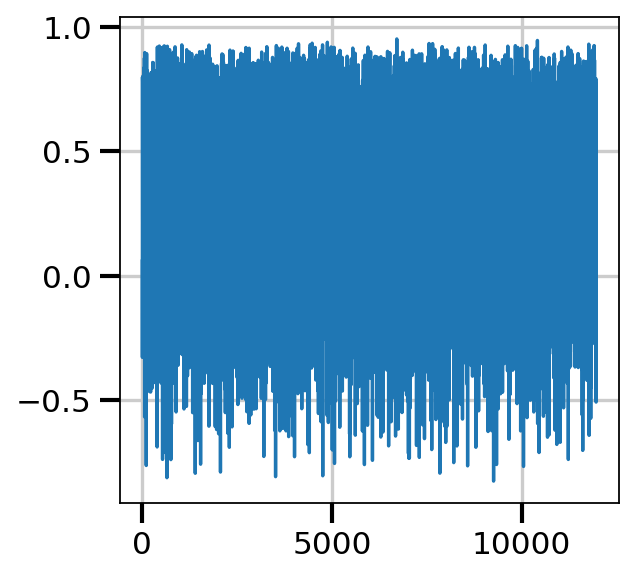

In [36]:
plt.plot(cor_list)

In [37]:
adata_new.var['pval'] = pval_list
adata_new.var['cor'] = cor_list

In [38]:
adata_new.write_h5ad("spatial_imputation_zeroshots.h5ad")

In [51]:
adata_new

AnnData object with n_obs × n_vars = 324 × 11968
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT', 'log1p_total_counts_MT', 'pct_counts_MT', 'n_counts', 'leiden', 'cluster', 'batch', 'celltype', 'str_batch', 'batch_id'
    var: 'gene_ids', 'feature_types', 'genome', 'MT', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'gene_name', 'id_in_vocab', 'n_counts', 'pval', 'cor'

In [35]:
adata_new.write_h5ad("spatial_impuration.h5ad")

In [ ]:
sc.pp.scale(adata_new) 
sc.tl.pca(adata_new)
sc.pp.neighbors(adata_new)
sc.tl.umap(adata_new)